In [1]:
# Installations and Imports 
!pip install tensorflow pandas pandas-ta pandas-datareader scikit-learn keras-tuner vaderSentiment -q
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import datetime
from alpha_vantage.timeseries import TimeSeries
import pandas_ta as ta
import pandas_datareader.data as web
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt

2025-10-01 09:45:13.212926: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
# Global Configuration 
CONFIG = {
    "alpha_vantage": {"key": "ALPHAVENTAGE_API_KEY", "symbol": "IBM"},
    "data": {"start_date": "2010-01-01", "end_date": datetime.date.today().strftime("%Y-%m-%d"), "target_column": "close", "window_size": 30},
    "relative_strength": {"etf": "XLK"},
    "sentiment": {"threshold": 0.03},
    "walk_forward": {"train_days": 500, "test_days": 90, "step": 120},
    "tuner": {"max_trials": 8, "epochs": 15},
    "training": {"epochs": 100, "batch_size": 32}
}

In [3]:
# Feature Engineering Function
def create_advanced_feature_dataset(config):
    ts = TimeSeries(key=config["alpha_vantage"]["key"], output_format='pandas')
    print(f"Fetching data for {config['alpha_vantage']['symbol']} and {config['relative_strength']['etf']}...")
    df, _ = ts.get_daily(config["alpha_vantage"]["symbol"], outputsize="full")
    df.sort_index(inplace=True)
    df = df.loc[config["data"]["start_date"]:config["data"]["end_date"]]
    df.columns = [col.split('. ')[1] for col in df.columns]

    etf_df, _ = ts.get_daily(config['relative_strength']['etf'], outputsize="full")
    etf_df.sort_index(inplace=True)
    etf_df.columns = [col.split('. ')[1] for col in etf_df.columns]
    df[f"{config['relative_strength']['etf']}_close"] = etf_df['close']
    df.ffill(inplace=True)
    df['relative_strength'] = df['close'] / df[f"{config['relative_strength']['etf']}_close"]

    analyzer = SentimentIntensityAnalyzer()
    df['price_change'] = df['close'].pct_change()
    df['headline'] = df['price_change'].apply(lambda change: f"Stock surges" if change > config["sentiment"]["threshold"] else (f"Stock plummets" if change < -config["sentiment"]["threshold"] else f"Stock stable"))
    df['sentiment'] = df['headline'].apply(lambda h: analyzer.polarity_scores(h)['compound'])

    df.ta.rsi(length=14, append=True)
    df.ta.macd(fast=12, slow=26, signal=9, append=True)
    df.ta.bbands(length=20, append=True)
    df.ta.obv(append=True)
    
    df['rsi_oversold'] = np.where(df['RSI_14'] < 30, 1, 0)
    df['rsi_overbought'] = np.where(df['RSI_14'] > 70, 1, 0)
    macd_line, signal_line = df['MACD_12_26_9'], df['MACDs_12_26_9']
    df['macd_bullish_cross'] = np.where((macd_line > signal_line) & (macd_line.shift(1) < signal_line.shift(1)), 1, 0)
    
    for lag in range(1, 4):
        df[f'close_lag_{lag}'] = df['close'].shift(lag)
        df[f'volume_lag_{lag}'] = df['volume'].shift(lag)
    
    df = df.drop(columns=['headline', 'price_change']).dropna().astype(np.float32)
    print(f"Feature engineering complete. Final dataset shape: {df.shape}")
    return df


In [4]:
# Supporting Functions and Model Definition
def create_windowed_data(data, window_size, target_col_index):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:(i + window_size)])
        y.append(data[i + window_size, target_col_index])
    return np.array(X), np.array(y)

def build_model_for_tuning(hp):
    model = keras.Sequential()
    model.add(Conv1D(filters=hp.Int('conv_filters', 32, 128, 32), kernel_size=hp.Choice('kernel_size', [3, 5]), activation='relu', input_shape=(CONFIG["data"]["window_size"], X_placeholder.shape[2])))
    model.add(MaxPooling1D(pool_size=2))
    model.add(GRU(units=hp.Int('gru_units', 40, 100, 20), return_sequences=True))
    model.add(GRU(units=hp.Int('gru_units_2', 40, 100, 20)))
    model.add(Dropout(hp.Float('dropout', 0.1, 0.5, 0.1)))
    model.add(Dense(1))
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])), loss='mean_squared_error')
    return model



In [5]:
# Hyperparameter Tuning
master_df = create_advanced_feature_dataset(CONFIG)
global X_placeholder
X_placeholder = np.zeros((1, CONFIG["data"]["window_size"], master_df.shape[1]))

print(f"\n--- Tuning Single, Robust Model ---")
tuning_slice_df = master_df.iloc[:CONFIG["walk_forward"]["train_days"]]
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(tuning_slice_df)
target_col_idx = tuning_slice_df.columns.get_loc(CONFIG["data"]["target_column"])
X_train_tuning, y_train_tuning = create_windowed_data(scaled_data, CONFIG["data"]["window_size"], target_col_idx)
X_placeholder = X_train_tuning

tuner = kt.RandomSearch(build_model_for_tuning, objective='val_loss', max_trials=CONFIG["tuner"]["max_trials"], executions_per_trial=1, directory='tuner_dir_final', project_name='final_model')
tuner.search(X_train_tuning, y_train_tuning, epochs=CONFIG["tuner"]["epochs"], validation_split=0.2, verbose=1)
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"--- Best Hyperparameters Found ---")

Fetching data for IBM and XLK...
Feature engineering complete. Final dataset shape: (3927, 27)

--- Tuning Single, Robust Model ---
Reloading Tuner from tuner_dir_final/final_model/tuner0.json
--- Best Hyperparameters Found ---


In [6]:
# Simplified Walk-Forward Validation Function
def run_single_model_walk_forward(df, config, best_hps):
    all_actuals, all_predictions, all_dates = [], [], []
    target_col = config["data"]["target_column"]
    print("\n--- Starting Single-Model Walk-Forward Validation ---")
    for i in range(0, len(df) - config["walk_forward"]["train_days"] - config["walk_forward"]["test_days"] + 1, config["walk_forward"]["step"]):
        train_slice = df.iloc[i : i + config["walk_forward"]["train_days"]]
        test_slice = df.iloc[i + config["walk_forward"]["train_days"] : i + config["walk_forward"]["train_days"] + config["walk_forward"]["test_days"]]
        print(f"\n--- FOLD: Training on {train_slice.index.min().date()} to {train_slice.index.max().date()} ---")

        scaler = MinMaxScaler(feature_range=(0, 1))
        scaled_train = scaler.fit_transform(train_slice)
        X_train, y_train = create_windowed_data(scaled_train, config["data"]["window_size"], train_slice.columns.get_loc(target_col))
        
        model = build_model_for_tuning(best_hps)
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        model.fit(X_train, y_train, epochs=config["training"]["epochs"], batch_size=config["training"]["batch_size"], validation_split=0.2, callbacks=[early_stopping], verbose=0)
        
        history = train_slice.iloc[-config["data"]["window_size"]:]
        fold_predictions = []
        for j in range(len(test_slice)):
            current_day = test_slice.iloc[j:j+1]
            prediction_input = pd.concat([history, current_day])
            scaled_input = scaler.transform(prediction_input)
            X_pred = np.array([scaled_input])
            scaled_pred = model.predict(X_pred, verbose=0)
            dummy = np.zeros((1, len(df.columns))); dummy[0, df.columns.get_loc(target_col)] = scaled_pred
            prediction = scaler.inverse_transform(dummy)[0, df.columns.get_loc(target_col)]
            fold_predictions.append(prediction)
            history = pd.concat([history.iloc[1:], current_day])

        all_predictions.extend(fold_predictions)
        all_actuals.extend(test_slice[target_col].values)
        all_dates.extend(test_slice.index)
    return pd.DataFrame({'Actual': all_actuals, 'Predicted': all_predictions}, index=pd.to_datetime(all_dates))



--- Starting Single-Model Walk-Forward Validation ---

--- FOLD: Training on 2010-02-22 to 2012-02-13 ---


/home/Tojo/miniconda3/envs/stock_env/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
W0000 00:00:1759311926.175487 3189926 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/tmp/ipykernel_3189926/2962244513.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



--- FOLD: Training on 2010-08-12 to 2012-08-03 ---


/tmp/ipykernel_3189926/2962244513.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dummy = np.zeros((1, len(df.columns))); dummy[0, df.columns.get_loc(target_col)] = scaled_pred
/tmp/ipykernel_3189926/2962244513.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dummy = np.zeros((1, len(df.columns))); dummy[0, df.columns.get_loc(target_col)] = scaled_pred
/tmp/ipykernel_3189926/2962244513.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dummy = np.zeros((


--- FOLD: Training on 2011-02-02 to 2013-01-29 ---


/tmp/ipykernel_3189926/2962244513.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dummy = np.zeros((1, len(df.columns))); dummy[0, df.columns.get_loc(target_col)] = scaled_pred
/tmp/ipykernel_3189926/2962244513.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dummy = np.zeros((1, len(df.columns))); dummy[0, df.columns.get_loc(target_col)] = scaled_pred
/tmp/ipykernel_3189926/2962244513.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dummy = np.zeros((


--- FOLD: Training on 2011-07-26 to 2013-07-22 ---


/tmp/ipykernel_3189926/2962244513.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dummy = np.zeros((1, len(df.columns))); dummy[0, df.columns.get_loc(target_col)] = scaled_pred
/tmp/ipykernel_3189926/2962244513.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dummy = np.zeros((1, len(df.columns))); dummy[0, df.columns.get_loc(target_col)] = scaled_pred
/tmp/ipykernel_3189926/2962244513.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dummy = np.zeros((


--- FOLD: Training on 2012-01-17 to 2014-01-10 ---


/tmp/ipykernel_3189926/2962244513.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dummy = np.zeros((1, len(df.columns))); dummy[0, df.columns.get_loc(target_col)] = scaled_pred
/tmp/ipykernel_3189926/2962244513.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dummy = np.zeros((1, len(df.columns))); dummy[0, df.columns.get_loc(target_col)] = scaled_pred
/tmp/ipykernel_3189926/2962244513.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dummy = np.zeros((


--- FOLD: Training on 2012-07-09 to 2014-07-03 ---


/tmp/ipykernel_3189926/2962244513.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dummy = np.zeros((1, len(df.columns))); dummy[0, df.columns.get_loc(target_col)] = scaled_pred
/tmp/ipykernel_3189926/2962244513.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dummy = np.zeros((1, len(df.columns))); dummy[0, df.columns.get_loc(target_col)] = scaled_pred
/tmp/ipykernel_3189926/2962244513.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dummy = np.zeros((


--- FOLD: Training on 2012-12-31 to 2014-12-23 ---


/tmp/ipykernel_3189926/2962244513.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dummy = np.zeros((1, len(df.columns))); dummy[0, df.columns.get_loc(target_col)] = scaled_pred
/tmp/ipykernel_3189926/2962244513.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dummy = np.zeros((1, len(df.columns))); dummy[0, df.columns.get_loc(target_col)] = scaled_pred
/tmp/ipykernel_3189926/2962244513.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dummy = np.zeros((


--- FOLD: Training on 2013-06-24 to 2015-06-17 ---


/tmp/ipykernel_3189926/2962244513.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dummy = np.zeros((1, len(df.columns))); dummy[0, df.columns.get_loc(target_col)] = scaled_pred
/tmp/ipykernel_3189926/2962244513.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dummy = np.zeros((1, len(df.columns))); dummy[0, df.columns.get_loc(target_col)] = scaled_pred
/tmp/ipykernel_3189926/2962244513.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dummy = np.zeros((


--- FOLD: Training on 2013-12-12 to 2015-12-07 ---


/tmp/ipykernel_3189926/2962244513.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dummy = np.zeros((1, len(df.columns))); dummy[0, df.columns.get_loc(target_col)] = scaled_pred
/tmp/ipykernel_3189926/2962244513.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dummy = np.zeros((1, len(df.columns))); dummy[0, df.columns.get_loc(target_col)] = scaled_pred
/tmp/ipykernel_3189926/2962244513.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dummy = np.zeros((


--- FOLD: Training on 2014-06-06 to 2016-05-31 ---


/tmp/ipykernel_3189926/2962244513.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dummy = np.zeros((1, len(df.columns))); dummy[0, df.columns.get_loc(target_col)] = scaled_pred
/tmp/ipykernel_3189926/2962244513.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dummy = np.zeros((1, len(df.columns))); dummy[0, df.columns.get_loc(target_col)] = scaled_pred
/tmp/ipykernel_3189926/2962244513.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dummy = np.zeros((


--- FOLD: Training on 2014-11-25 to 2016-11-17 ---


/tmp/ipykernel_3189926/2962244513.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dummy = np.zeros((1, len(df.columns))); dummy[0, df.columns.get_loc(target_col)] = scaled_pred
/tmp/ipykernel_3189926/2962244513.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dummy = np.zeros((1, len(df.columns))); dummy[0, df.columns.get_loc(target_col)] = scaled_pred
/tmp/ipykernel_3189926/2962244513.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dummy = np.zeros((


--- FOLD: Training on 2015-05-20 to 2017-05-12 ---


/tmp/ipykernel_3189926/2962244513.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dummy = np.zeros((1, len(df.columns))); dummy[0, df.columns.get_loc(target_col)] = scaled_pred
/tmp/ipykernel_3189926/2962244513.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dummy = np.zeros((1, len(df.columns))); dummy[0, df.columns.get_loc(target_col)] = scaled_pred
/tmp/ipykernel_3189926/2962244513.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dummy = np.zeros((


--- FOLD: Training on 2015-11-09 to 2017-11-01 ---


/tmp/ipykernel_3189926/2962244513.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dummy = np.zeros((1, len(df.columns))); dummy[0, df.columns.get_loc(target_col)] = scaled_pred
/tmp/ipykernel_3189926/2962244513.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dummy = np.zeros((1, len(df.columns))); dummy[0, df.columns.get_loc(target_col)] = scaled_pred
/tmp/ipykernel_3189926/2962244513.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dummy = np.zeros((


--- FOLD: Training on 2016-05-03 to 2018-04-26 ---


/tmp/ipykernel_3189926/2962244513.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dummy = np.zeros((1, len(df.columns))); dummy[0, df.columns.get_loc(target_col)] = scaled_pred
/tmp/ipykernel_3189926/2962244513.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dummy = np.zeros((1, len(df.columns))); dummy[0, df.columns.get_loc(target_col)] = scaled_pred
/tmp/ipykernel_3189926/2962244513.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dummy = np.zeros((


--- FOLD: Training on 2016-10-21 to 2018-10-16 ---


/tmp/ipykernel_3189926/2962244513.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dummy = np.zeros((1, len(df.columns))); dummy[0, df.columns.get_loc(target_col)] = scaled_pred
/tmp/ipykernel_3189926/2962244513.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dummy = np.zeros((1, len(df.columns))); dummy[0, df.columns.get_loc(target_col)] = scaled_pred
/tmp/ipykernel_3189926/2962244513.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dummy = np.zeros((


--- FOLD: Training on 2017-04-17 to 2019-04-10 ---


/tmp/ipykernel_3189926/2962244513.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dummy = np.zeros((1, len(df.columns))); dummy[0, df.columns.get_loc(target_col)] = scaled_pred
/tmp/ipykernel_3189926/2962244513.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dummy = np.zeros((1, len(df.columns))); dummy[0, df.columns.get_loc(target_col)] = scaled_pred
/tmp/ipykernel_3189926/2962244513.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dummy = np.zeros((


--- FOLD: Training on 2017-10-05 to 2019-10-01 ---


/tmp/ipykernel_3189926/2962244513.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dummy = np.zeros((1, len(df.columns))); dummy[0, df.columns.get_loc(target_col)] = scaled_pred
/tmp/ipykernel_3189926/2962244513.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dummy = np.zeros((1, len(df.columns))); dummy[0, df.columns.get_loc(target_col)] = scaled_pred
/tmp/ipykernel_3189926/2962244513.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dummy = np.zeros((


--- FOLD: Training on 2018-03-29 to 2020-03-24 ---


/tmp/ipykernel_3189926/2962244513.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dummy = np.zeros((1, len(df.columns))); dummy[0, df.columns.get_loc(target_col)] = scaled_pred
/tmp/ipykernel_3189926/2962244513.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dummy = np.zeros((1, len(df.columns))); dummy[0, df.columns.get_loc(target_col)] = scaled_pred
/tmp/ipykernel_3189926/2962244513.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dummy = np.zeros((


--- FOLD: Training on 2018-09-19 to 2020-09-14 ---


/tmp/ipykernel_3189926/2962244513.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dummy = np.zeros((1, len(df.columns))); dummy[0, df.columns.get_loc(target_col)] = scaled_pred
/tmp/ipykernel_3189926/2962244513.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dummy = np.zeros((1, len(df.columns))); dummy[0, df.columns.get_loc(target_col)] = scaled_pred
/tmp/ipykernel_3189926/2962244513.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dummy = np.zeros((


--- FOLD: Training on 2019-03-14 to 2021-03-08 ---


/tmp/ipykernel_3189926/2962244513.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dummy = np.zeros((1, len(df.columns))); dummy[0, df.columns.get_loc(target_col)] = scaled_pred
/tmp/ipykernel_3189926/2962244513.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dummy = np.zeros((1, len(df.columns))); dummy[0, df.columns.get_loc(target_col)] = scaled_pred
/tmp/ipykernel_3189926/2962244513.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dummy = np.zeros((


--- FOLD: Training on 2019-09-04 to 2021-08-26 ---


/tmp/ipykernel_3189926/2962244513.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dummy = np.zeros((1, len(df.columns))); dummy[0, df.columns.get_loc(target_col)] = scaled_pred
/tmp/ipykernel_3189926/2962244513.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dummy = np.zeros((1, len(df.columns))); dummy[0, df.columns.get_loc(target_col)] = scaled_pred
/tmp/ipykernel_3189926/2962244513.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dummy = np.zeros((


--- FOLD: Training on 2020-02-26 to 2022-02-16 ---


/tmp/ipykernel_3189926/2962244513.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dummy = np.zeros((1, len(df.columns))); dummy[0, df.columns.get_loc(target_col)] = scaled_pred
/tmp/ipykernel_3189926/2962244513.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dummy = np.zeros((1, len(df.columns))); dummy[0, df.columns.get_loc(target_col)] = scaled_pred
/tmp/ipykernel_3189926/2962244513.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dummy = np.zeros((


--- FOLD: Training on 2020-08-17 to 2022-08-10 ---


/tmp/ipykernel_3189926/2962244513.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dummy = np.zeros((1, len(df.columns))); dummy[0, df.columns.get_loc(target_col)] = scaled_pred
/tmp/ipykernel_3189926/2962244513.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dummy = np.zeros((1, len(df.columns))); dummy[0, df.columns.get_loc(target_col)] = scaled_pred
/tmp/ipykernel_3189926/2962244513.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dummy = np.zeros((


--- FOLD: Training on 2021-02-08 to 2023-02-01 ---


/tmp/ipykernel_3189926/2962244513.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dummy = np.zeros((1, len(df.columns))); dummy[0, df.columns.get_loc(target_col)] = scaled_pred
/tmp/ipykernel_3189926/2962244513.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dummy = np.zeros((1, len(df.columns))); dummy[0, df.columns.get_loc(target_col)] = scaled_pred
/tmp/ipykernel_3189926/2962244513.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dummy = np.zeros((


--- FOLD: Training on 2021-07-30 to 2023-07-26 ---


/tmp/ipykernel_3189926/2962244513.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dummy = np.zeros((1, len(df.columns))); dummy[0, df.columns.get_loc(target_col)] = scaled_pred
/tmp/ipykernel_3189926/2962244513.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dummy = np.zeros((1, len(df.columns))); dummy[0, df.columns.get_loc(target_col)] = scaled_pred
/tmp/ipykernel_3189926/2962244513.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dummy = np.zeros((


--- FOLD: Training on 2022-01-20 to 2024-01-17 ---


/tmp/ipykernel_3189926/2962244513.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dummy = np.zeros((1, len(df.columns))); dummy[0, df.columns.get_loc(target_col)] = scaled_pred
/tmp/ipykernel_3189926/2962244513.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dummy = np.zeros((1, len(df.columns))); dummy[0, df.columns.get_loc(target_col)] = scaled_pred
/tmp/ipykernel_3189926/2962244513.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dummy = np.zeros((


--- FOLD: Training on 2022-07-14 to 2024-07-10 ---


/tmp/ipykernel_3189926/2962244513.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dummy = np.zeros((1, len(df.columns))); dummy[0, df.columns.get_loc(target_col)] = scaled_pred
/tmp/ipykernel_3189926/2962244513.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dummy = np.zeros((1, len(df.columns))); dummy[0, df.columns.get_loc(target_col)] = scaled_pred
/tmp/ipykernel_3189926/2962244513.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dummy = np.zeros((


--- FOLD: Training on 2023-01-04 to 2024-12-30 ---


/tmp/ipykernel_3189926/2962244513.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dummy = np.zeros((1, len(df.columns))); dummy[0, df.columns.get_loc(target_col)] = scaled_pred
/tmp/ipykernel_3189926/2962244513.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dummy = np.zeros((1, len(df.columns))); dummy[0, df.columns.get_loc(target_col)] = scaled_pred
/tmp/ipykernel_3189926/2962244513.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dummy = np.zeros((


--- FINAL BACKTEST RESULTS ---
Robust Directional Accuracy: 49.98%
Mean Absolute Error (MAE): $10.72
Root Mean Squared Error (RMSE): $19.75


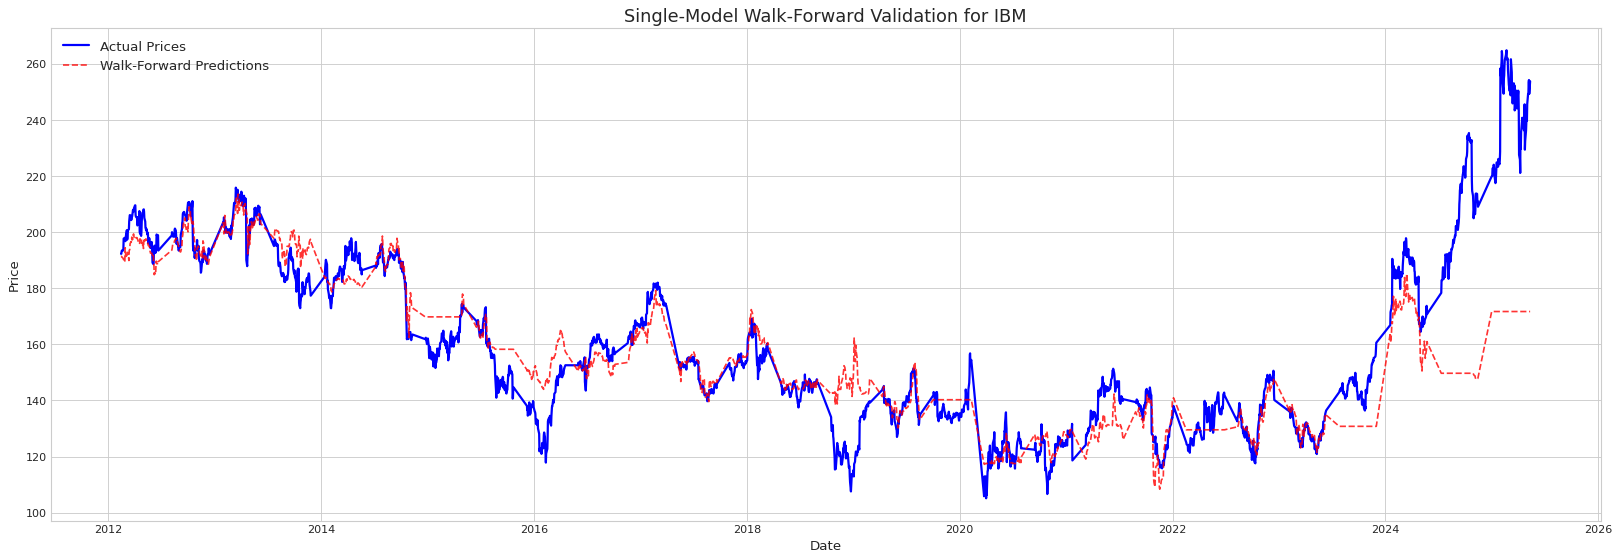

In [7]:

# Execution and Final Analysis
results_df = run_single_model_walk_forward(master_df, CONFIG, best_hps)
if not results_df.empty:
    results_df.dropna(inplace=True)
    actual_direction = np.diff(results_df['Actual']) > 0
    predicted_direction = np.diff(results_df['Predicted']) > 0
    final_directional_accuracy = np.mean(actual_direction == predicted_direction) * 100
    mae = np.mean(np.abs(results_df['Predicted'] - results_df['Actual']))
    rmse = np.sqrt(np.mean((results_df['Predicted'] - results_df['Actual'])**2))
    print(f"\n--- FINAL BACKTEST RESULTS ---")
    print(f"Robust Directional Accuracy: {final_directional_accuracy:.2f}%")
    print(f"Mean Absolute Error (MAE): ${mae:.2f}")
    print(f"Root Mean Squared Error (RMSE): ${rmse:.2f}")

    plt.style.use('seaborn-v0_8-whitegrid')
    fig = figure(figsize=(25, 8), dpi=80)
    plt.plot(results_df['Actual'], label="Actual Prices", color="blue", linewidth=2)
    plt.plot(results_df['Predicted'], label="Walk-Forward Predictions", color="red", linestyle='--', alpha=0.8)
    plt.title(f"Single-Model Walk-Forward Validation for {CONFIG['alpha_vantage']['symbol']}", fontsize=16)
    plt.xlabel("Date", fontsize=12); plt.ylabel("Price", fontsize=12); plt.legend(fontsize=12)
    plt.show()